Saving current notebook before running...
Creating new Git commit of all tracked files...
Short Git hash for current version: 0fc3f06
    Purpose: Investigate whether THD bump at 9600 Hz is an anomaly
    Device: White Patch Cable
    # Trials: 5
    
    Generation Settings:
    	Tone amplitude: 0.5
    	Duration: 1.5 seconds
    	Sampling frequency: 44100.0 Hz
    	Min Frequency: 9500.0 Hz
    	Max frequency: 9700 Hz
    	Frequency spacing: 1 Hz
    
    Analysis Settings:
    	Fundamental frequency notch width (fraction of center frequency): 0.1
    	Fundamental frequency search width (fraction of center frequency): 0.01
    	Time ignored at beginning of recording: 0.25 seconds
    	Time ignored at end of recording: 0.25 seconds
    	Resuling DFT bin size: 1.0 Hz
    	Saturation threshold: 0.95
    	# of samples allowed at saturation threshold: 0
    	Underdrive threshold: 0.1     
    Execution settings:
	Saved data file prefix: White-Patch-Cable_0fc3f06

    Experiment artifacts a

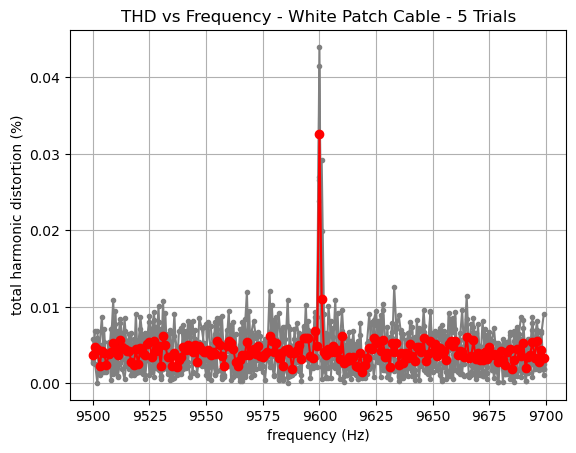

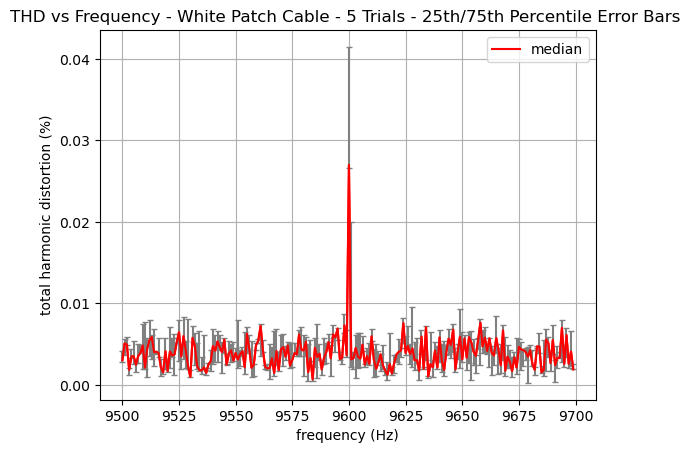

In [56]:
# restart kernel before execution to remove all variables
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import math
import time
import sys
import sounddevice as sd
# import subprocess
# import pyaudio

from scipy.io import savemat

import git 
import os
from ipylab import JupyterFrontEnd
import datetime

# Save file in Jupyter Notebook before execution and commit to Git repo
app = JupyterFrontEnd()
app.commands.execute('docmanager:save')
print('Saving current notebook before running...')
time.sleep(1)

# Generate tone
# fc_approx = 8000 # approximate fc, will choose fc to be a factor of fs, will analyze 1 second of data, so this should be an integer
fs = 44.1e3

# experiment settings
numTrials = 5
expPurpose = 'Investigate whether THD bump at 9600 Hz is an anomaly'#'Wideband characterization'
# deviceUnderTest = 'THD Triad 80043 RevD' # used as file prefix for saved data and corresponding plots
deviceUnderTest = 'White Patch Cable' # used as file prefix for saved data and corresponding plots
deviceUnderTestHyph = deviceUnderTest.replace(" ", "-")

# tone generation settings
duration = 1.5 # in seconds
toneAmplitude = .5 # gain factor, need to appropriately set to avoid clipping, calibrate with computer volume at 50%
minFreqToTest = 9500.0 #100 # in Hz
maxFreqToTest = 9700 #fs/4 # in Hz
freqSpacing = 1#100.0 # in Hz

# analysis settings
fundFreqNotchWidthFract = .1 # width of the brick wall notch filter in frequency domain when measuring distortion expressed as a fraction of the fundamental frequency
fundFreqSearchWidthFract = .01 # width of the range to search for max amplitude relative to fundamental frequency
startBuffer = 0.25 # number of seconds from beginning of recorded file to ignore
endBuffer = 0.25 # number of seconds from end of recorded file to ignore
saturationThreshold = .95 # max allowed value of the samples before declaring saturated input
numSampsAtSatToAllow = 0 # number of samples to allow above saturation threshold
underDriveThreshold = .1 # if max value of signal is not above this, then signal might not be present
# archive code state for this experiment

currentConfig = f'\
    Purpose: {expPurpose}\n\
    Device: {deviceUnderTest}\n\
    # Trials: {numTrials}\n\
    \n\
    Generation Settings:\n\
    \tTone amplitude: {toneAmplitude}\n\
    \tDuration: {duration} seconds\n\
    \tSampling frequency: {fs} Hz\n\
    \tMin Frequency: {minFreqToTest} Hz\n\
    \tMax frequency: {maxFreqToTest} Hz\n\
    \tFrequency spacing: {freqSpacing} Hz\n\
    \n\
    Analysis Settings:\n\
    \tFundamental frequency notch width (fraction of center frequency): {fundFreqNotchWidthFract}\n\
    \tFundamental frequency search width (fraction of center frequency): {fundFreqSearchWidthFract}\n\
    \tTime ignored at beginning of recording: {startBuffer} seconds\n\
    \tTime ignored at end of recording: {endBuffer} seconds\n\
    \tResuling DFT bin size: {fs/((duration-startBuffer-endBuffer)*fs)} Hz\n\
    \tSaturation threshold: {saturationThreshold}\n\
    \t# of samples allowed at saturation threshold: {numSampsAtSatToAllow}\n\
    \tUnderdrive threshold: {underDriveThreshold}\
    '

print('Creating new Git commit of all tracked files...')
currRepo = git.Repo(os.getcwd())
changedFiles = [item.a_path for item in currRepo.index.diff(None)]
currRepo.git.add(changedFiles)
currRepo.index.commit(f'Experiment execution\n {currentConfig}')
# currRepo.remote.origin.push() # push to origin

# gitShortHash = subprocess.check_output('git rev-parse --short HEAD').strip().decode()
sha = currRepo.head.commit.hexsha
short_sha = currRepo.git.rev_parse(sha, short=7)
# assert no currRepo.is_dirty()
print(f'Short Git hash for current version: {short_sha}')
# raise Exception('I am tired')

# execution settings
debugOn = False
savedDataFilePrefix = f'{deviceUnderTestHyph}_{short_sha}'

# create new folder to save results
datafolder = os.path.join(os.getcwd(),savedDataFilePrefix)                          
if not os.path.exists(datafolder):
    os.makedirs(datafolder)

print(f'{currentConfig} \n\
    Execution settings:\n\tSaved data file prefix: {savedDataFilePrefix}\n\n\
    Experiment artifacts are stored in:\n\t{datafolder}')
      
freqsToTest =  np.arange(minFreqToTest,maxFreqToTest,freqSpacing) #np.array([7100]) #np.arange(100,fs/4,1000) #
thdAll = np.zeros((freqsToTest.shape[0],numTrials))

expStartTime = datetime.datetime.now()
estExpDuration = numTrials*len(freqsToTest)*duration # in seconds, does not account for overhead
estStopTime = expStartTime + datetime.timedelta(seconds=estExpDuration)

print(f'\
Experiment start time: {expStartTime.strftime("%Y-%m-%d %H:%M:%S")}\n\
Approximate stop time (not including execution overhead): {estStopTime.strftime("%Y-%m-%d %H:%M:%S")}\
')
for trialIdx in range(0,numTrials):
    print(f'Trial {trialIdx+1}/{numTrials}')

    for freqIdx in range(0,len(freqsToTest)):
        fc = freqsToTest[freqIdx]
        # fc = fs/round(fs/fc_approx)
        # bufferSize = 512

        t = np.arange(0,duration,1/fs)
        signalOrig = toneAmplitude * np.sin(2*math.pi*fc*t)
        # tone1 = toneAmplitude * np.sin(2*math.pi*fc*1*t)
        # tone2 = toneAmplitude * np.sin(2*math.pi*fc*2*t)
        # tone3 = toneAmplitude * np.sin(2*math.pi*fc*3*t)
        # signalOrig = tone1 + tone2 + tone3

        # # Add synthetic distortion
        # maxHarmonic = math.floor(fs/2/fc)
        # harmonicCoeff = 1e-4*np.random.rand(maxHarmonic-1)

        # signalDistortions = np.zeros(signalOrig.shape)
        # for harmNum in range(2,maxHarmonic):
        #     signalDistortions = signalDistortions + harmonicCoeff[harmNum-2]*np.sin(2*math.pi*fc*t*harmNum)

        # signalToAnalyze = signalOrig + signalDistortions

        # Playback and record signal
        signalToAnalyzeRaw = sd.playrec(signalOrig, fs, channels=1)
        sd.wait()

        signalToAnalyze = signalToAnalyzeRaw[math.ceil(startBuffer*fs):(len(signalToAnalyzeRaw)-math.ceil(endBuffer*fs))]
        #savemat('recSig.mat',{'y':signalToAnalyze,'fs':fs,'tone1':tone1,'tone2':tone2,'tone3':tone3})

        sampsAboveSatTH = np.sum(abs(signalToAnalyze)>saturationThreshold)
        if sampsAboveSatTH > numSampsAtSatToAllow:
            print(f'\t{sampsAboveSatTH} samples were above saturation threshold ({saturationThreshold}). \
            Tone amplitude is {toneAmplitude}.')
              
        if np.max(abs(signalToAnalyze))<underDriveThreshold:
            print(f'\tThe maximum value of the recorded signal is less than the underdrive threshold ({underDriveThreshold}). Tone amplitude is {toneAmplitude}.\n\n \
            \tCheck to ensure:\n \
            \t\t- The device under test is connected. \n \
            \t\t- The correct recording and playback devices were selected.\n \
            \t\t- Audio output is unmuted')
        # measure spectrum
        spectrum = np.fft.rfft(signalToAnalyze,axis=0)
        fftBin = fs/len(signalToAnalyze)
        # freqX = np.arange(-fs/2,fs/2,fftBin)

        fcIdxTheoretical = round(fc/fftBin)
        fcOffcenter = fc/fftBin - fcIdxTheoretical

        if fcOffcenter > 1e-3:
            print("DFT bin not centered on carrier frequency. Unexpected results may occur due to spectral leakage.")

        fundFreqSearchWidthHz = fundFreqSearchWidthFract*fc # Hz, width of the brick wall notch filter in frequency domain when measuring distortion
        fundFreqSearchWidthHzSamps = fundFreqSearchWidthHz/fftBin
        fundFreqSearchWidthHzSampsHW = int(np.ceil(fundFreqSearchWidthHzSamps/2)) # round up
        minSearchIdx = int(np.max([0,fcIdxTheoretical-fundFreqSearchWidthHzSampsHW]))
        maxSearchIdx = int(np.min([len(spectrum)-1,fcIdxTheoretical+fundFreqSearchWidthHzSampsHW])) 
        fcIdx = int(minSearchIdx + np.argmax(abs(spectrum[minSearchIdx:maxSearchIdx])))
        # savemat('recSig.mat',{'fundFreqSearchWidthFract':fundFreqSearchWidthFract,\
        #                       'fcIdxTheoretical':fcIdxTheoretical,\
        #                       'freqSpectrum':spectrum,\
        #                       'fs':fs,\
        #                       'minSearchIdx':minSearchIdx,\
        #                       'maxSearchIdx':maxSearchIdx,\
        #                       'fcIdx':fcIdx,\
        #                       'fundFreqSearchWidthHz':fundFreqSearchWidthHz,\
        #                       'fundFreqSearchWidthHzSamps':fundFreqSearchWidthHzSamps,\
        #                       'fundFreqSearchWidthHzSampsHW':fundFreqSearchWidthHzSampsHW})
        if debugOn:
            print(f'Correct fcIdx by %d DFT bins' % (fcIdxTheoretical-fcIdx))

        carrierAmpl = abs(spectrum[fcIdx][0])

        if np.mod(len(spectrum),2)==0: # even number of points in spectrum
            lastPosFreqIdx = int((fs/2)/fftBin)
        else: # odd number of points in spectrum
            lastPosFreqIdx = int((fs/2 - fftBin)/fftBin)

        # measure power of all signals other than the fundamental frequency
        spectrumNoFund = spectrum.copy()

        # apply "brick wall" notch filter in spectrum (i.e. zero out frequency components around fundamental frequency
        fundFreqNotchWidthHz = fundFreqNotchWidthFract*fc # Hz, width of the brick wall notch filter in frequency domain when measuring distortion
        fundFreqNotchWidthHzSamps = fundFreqNotchWidthHz/fftBin
        fundFreqNotchWidthHzSampsHW = int(np.ceil(fundFreqNotchWidthHzSamps/2)) # round up
        minNotchIdx = int(np.max([0,fcIdx-fundFreqNotchWidthHzSampsHW]))
        maxNotchIdx = int(np.min([len(spectrumNoFund),fcIdx+fundFreqNotchWidthHzSampsHW]))
        spectrumNoFund[minNotchIdx:maxNotchIdx] = 0

        harmonicAmpl = np.sqrt(np.sum(np.square(abs(spectrumNoFund))))

        # measure power of harmonics signals of the fundamental frequency
        harmonicIdx = range(2*fcIdx,lastPosFreqIdx,fcIdx)
        harmonicAmpl = np.sqrt(np.sum(np.square(abs(spectrum[harmonicIdx]))))

        measTHD = harmonicAmpl/carrierAmpl*100
        print("\tTHD (%d Hz): %.2f%%" % (fc,measTHD))
        # print("freqIdx: %d" % (freqIdx))
        thdAll[freqIdx][trialIdx] = measTHD

        if debugOn:
            # Plot time domain signal
            plt.plot(signalToAnalyze[0:int(10/fc*fs-1)])
            plt.title(f'Recorded Signal %d Hz' % fc)
            plt.xlabel('time (samples)')
            plt.ylabel('magnitude')
            plt.grid(visible=True,which='both',axis='both')
            plt.show()

            # Plot positive frequency spectrum showing fundamental frequency
            freqX = np.fft.fftfreq(len(signalToAnalyze), d=1./fs)
            if np.mod(len(spectrum),2)==0: # even number of points in spectrum
                freqXPos = np.arange(0,int(fs/2),int(fftBin))
            else: # odd number of points in spectrum
                freqXPos = np.arange(0,int(fs/2-fftBin),int(fftBin))
            # plt.plot(freqXPos,abs(spectrum[range(0,len(freqXPos))]))
            # plt.plot(freqXPos[fcIdx],abs(spectrum[fcIdx]),marker="*")
            # plt.plot(freqXPos[harmonicIdx],abs(spectrum[harmonicIdx]),linestyle='None',marker="o")
            plt.plot(freqXPos,20*np.log10(abs(spectrum[range(0,len(freqXPos))])))
            plt.plot(freqXPos[fcIdx],20*np.log10(abs(spectrum[fcIdx])),marker="*")
            plt.plot(freqXPos[harmonicIdx],20*np.log10(abs(spectrum[harmonicIdx])),linestyle='None',marker='o')
            plt.title(f'Recorded Signal Spectrum %d Hz' % fc)
            plt.xlabel('frequency (Hz)')
            plt.grid(visible=True,which='both',axis='both')
            plt.show()

            # Plot positive frequency spectrum removing fundamental frequency
            # plt.plot(freqXPos,abs(spectrumNoFund[range(0,len(freqXPos))]))
            # plt.plot(freqXPos[fcIdx],abs(spectrumNoFund[fcIdx]),marker="*")
            # plt.plot(freqXPos[harmonicIdx],abs(spectrumNoFund[harmonicIdx]),linestyle='None',marker="o")
            plt.plot(freqXPos,20*np.log10(abs(spectrumNoFund[range(0,len(freqXPos))])))
            plt.plot(freqXPos[fcIdx],20*np.log10(abs(spectrumNoFund[fcIdx])),marker="*")
            plt.plot(freqXPos[harmonicIdx],20*np.log10(abs(spectrumNoFund[harmonicIdx])),linestyle='None',marker='o')
            plt.title(f'Recorded Signal Spectrum %d Hz - Fundamental Removed' % fc)
            plt.xlabel('frequency (Hz)')
            plt.grid(visible=True,which='both',axis='both')
            plt.show()

        time.sleep(.5)
        savemat(os.path.join(datafolder,f'{savedDataFilePrefix}.mat'),{'fs':fs,\
                                              'numTrials':numTrials,\
                                              'expPurpose':expPurpose,\
                                              'deviceUnderTest':deviceUnderTest,\
                                              'duration':duration,\
                                              'toneAmplitude':toneAmplitude,\
                                              'minFreqToTest':minFreqToTest,\
                                              'maxFreqToTest':maxFreqToTest,\
                                              'freqSpacing':freqSpacing,\
                                              'freqsToTest':freqsToTest,\
                                              'fundFreqNotchWidthFract':fundFreqNotchWidthFract,\
                                              'fundFreqSearchWidthFract':fundFreqSearchWidthFract,\
                                              'startBuffer':startBuffer,\
                                              'endBuffer':endBuffer,\
                                              'saturationThreshold':saturationThreshold,\
                                              'numSampsAtSatToAllow':numSampsAtSatToAllow,\
                                              'underDriveThreshold':underDriveThreshold,
                                              'thdAll':thdAll,\
                                              'sha':sha,\
                                             }) # save results after every trial in case experiment is interrupted
        
# Plot each trial as a separate line graph
plotDesc = 'linePerTrialWAvg'
thdAvg = np.average(thdAll,axis=1)
for trialIdx in range(0,numTrials):
    # plt.plot(freqsToTest,thdAll[:,trialIdx],'k',label=f'Trial {trialIdx+1}')
    lh, = plt.plot(freqsToTest,thdAll[:,trialIdx],marker='.',color=(.5,.5,.5))
lh.set_label('Trials')
plt.plot(freqsToTest,thdAvg,'r-',marker='o',label='Average')
plt.title(f'THD vs Frequency - {deviceUnderTest} - {numTrials} Trials')
plt.xlabel('frequency (Hz)')
plt.ylabel('total harmonic distortion (%)')
plt.grid(visible=True,which='both',axis='both')
plt.savefig(os.path.join(datafolder,f'{savedDataFilePrefix}_{plotDesc}.png'), bbox_inches='tight')
plt.show()

# Make single line graph with error bars at the 25th and 75th percentiles
plotDesc = 'lineErrorBars'
thdAvg = np.average(thdAll,axis=1)
thdMed = np.median(thdAll,axis=1)
upperErr = np.percentile(thdAll,75,axis=1) - thdMed
lowerErr = thdMed - np.percentile(thdAll,25,axis=1)
thdErr = np.stack((lowerErr,upperErr),axis=0)
plt.plot(freqsToTest,thdMed,color='r',label='median')
plt.errorbar(freqsToTest,thdMed,yerr=thdErr,ecolor='grey',color='r',capsize=2)
plt.legend()
plt.title(f'THD vs Frequency - {deviceUnderTest} - {numTrials} Trials - 25th/75th Percentile Error Bars')
plt.xlabel('frequency (Hz)')
plt.ylabel('total harmonic distortion (%)')
plt.grid(visible=True,which='both',axis='both')
plt.savefig(os.path.join(datafolder,f'{savedDataFilePrefix}_{plotDesc}.png'), bbox_inches='tight')


In [330]:
# Find maximum amplitude of tone, output linear chirp multiple times and check for saturation
# Make sure windows audio output is not muted and volume is set to 50%
fs = 44.1e3

# Experiment settings
minFreqToTest = 100.0 # in Hz
maxFreqToTest = fs/4 # in Hz
duration = 15 # in seconds
numTrials = 10 # number of chirps output during single recording
minAmpToTest = .5
maxAmptToTest = 2
amplitudeDigitsPrecision = 2

amplitudeIncr = .1 

# Analysis settings
startBuffer = 0.25 # number of seconds from beginning of recorded file to ignore
endBuffer = 0.25 # number of seconds from end of recorded file to ignore
saturationThreshold = .95
numSampsAtSatToAllow = 0

# Execution settings
debugOn = False

# derive additional static values from configuration settings
timePerChirp = duration/numTrials
chirpRate = (maxFreqToTest-minFreqToTest)/timePerChirp
t = np.arange(0,duration,1/fs)

# initialize loop variables
notSaturated = True
toneAmplitude = minAmpToTest
sampsAboveSatTHPrevToneAmp = 0
lastUnsatAmpl = -1
while notSaturated and (toneAmplitude <= maxAmptToTest):
    print(f'Testing tone amplitude {toneAmplitude}...')
    signalOrig = toneAmplitude * np.sin(2*math.pi*chirpRate*t**2)
    
    # Playback and record signal
    signalToAnalyzeRaw = sd.playrec(signalOrig, fs, channels=1)
    sd.wait()
    signalToAnalyze = signalToAnalyzeRaw[math.ceil(startBuffer*fs):(len(signalToAnalyzeRaw)-math.ceil(endBuffer*fs))]

    # Check for saturation (values with magnitude near 1)
    sampsAboveSatTH = np.sum(abs(signalToAnalyze)>saturationThreshold)
    if sampsAboveSatTH > numSampsAtSatToAllow:
        print(f'\tSATURATED at {toneAmplitude}\n\
        \t{sampsAboveSatTH} samples above saturation threshold ({saturationThreshold})')
        
        # if level of desired precision is not reached yet, then back off on
        # the amplitude by one increment and continue the search at greater level of precision        
        if amplitudeIncr > 10**(-amplitudeDigitsPrecision):
            toneAmplitude = toneAmplitude - amplitudeIncr
            amplitudeIncr = amplitudeIncr/10
            print(f'\tResetting amplitude to {toneAmplitude} and decreasing increment to {amplitudeIncr}')
        else:        
            notSaturated = False
            if lastUnsatAmpl<0:
                print(f'\tUnable to find a tone amplitude that does not saturate the recorder. Try reducing the lower search range or computer volume and try again.')
            else:
                print(f'\tMax unsaturated tone amplitude is: {lastUnsatAmpl}\n\
                {sampsAboveSatTHPrevToneAmp} samples above saturation threshold ({saturationThreshold})')
    else:
        print('\tnot saturated')
        lastUnsatAmpl = toneAmplitude
        sampsAboveSatTHPrevToneAmp = sampsAboveSatTH
    
    
    # if debugOn:
    #     # Plot time domain signal
    #     plt.plot(signalToAnalyze[0:int(10/fc*fs-1)])
    #     plt.title(f'Recorded Signal %d Hz' % fc)
    #     plt.xlabel('time (samples)')
    #     plt.ylabel('magnitude')
    #     plt.grid(visible=True,which='both',axis='both')
    #     plt.show()

    #     # Plot spectrogram
    #     freqRes = (maxFreqToTest - minFreqToTest)/10
    #     sampsPerFFTApprox = fs/freqRes            
    #     sampsPerFFT = int(2**np.ceil(np.log2(sampsPerFFTApprox))) # round up to power of 2
    #     overlapRatio = 0
    #     overlapSamps = int(sampsPerFFT*overlapRatio) # will always be integer since FFT size is even
    #     savemat('recSig.mat',{'signalToAnalyze':signalToAnalyze,\
    #                           'fs':fs,\
    #                           'sampsPerFFT':sampsPerFFT,\
    #                           'overlapSamps':overlapSamps})
    #     plt.specgram(signalToAnalyze,NFFT=sampsPerFFT,Fs=fs,noverlap=overlapSamps)
    #     # # Plot positive frequency spectrum showing fundamental frequency
    #     # freqX = np.fft.fftfreq(len(signalToAnalyze), d=1./fs)
    #     # if np.mod(len(spectrum),2)==0: # even number of points in spectrum
    #     #     freqXPos = np.arange(0,int(fs/2),int(fftBin))
    #     # else: # odd number of points in spectrum
    #     #     freqXPos = np.arange(0,int(fs/2-fftBin),int(fftBin))
    #     # # plt.plot(freqXPos,abs(spectrum[range(0,len(freqXPos))]))
    #     # # plt.plot(freqXPos[fcIdx],abs(spectrum[fcIdx]),marker="*")
    #     # # plt.plot(freqXPos[harmonicIdx],abs(spectrum[harmonicIdx]),linestyle='None',marker="o")
    #     # plt.plot(freqXPos,20*np.log10(abs(spectrum[range(0,len(freqXPos))])))
    #     # plt.plot(freqXPos[fcIdx],20*np.log10(abs(spectrum[fcIdx])),marker="*")
    #     # plt.plot(freqXPos[harmonicIdx],20*np.log10(abs(spectrum[harmonicIdx])),linestyle='None',marker='o')
    #     # plt.title(f'Recorded Signal Spectrum %d Hz' % fc)
    #     # plt.xlabel('frequency (Hz)')
    #     # plt.grid(visible=True,which='both',axis='both')
    #     # plt.show()
    toneAmplitude = toneAmplitude + amplitudeIncr

Testing tone amplitude 0.5...
	not saturated
Testing tone amplitude 0.6...
	SATURATED at 0.6
        	125665 samples above saturation threshold (0.95)
	Resetting amplitude to 0.5 and decreasing increment to 0.01
Testing tone amplitude 0.51...
	SATURATED at 0.51
        	2282 samples above saturation threshold (0.95)
	Max tone amplitude is: 0.5
                	0 samples above saturation threshold (0.95)
